## Pipelines
Instead of uploading a model (estimator), it is also possible to upload a sklearn Pipeline object which includes not only the estimator, but also some preprocessing or postprocessing function. The following notebook demonstrates the use of a Pipeline consisting of a StandardScaler and a covariance estimator.

In [1]:
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

In [2]:
amount_of_samples = 250
data = np.random.randint(0, 25, size=(amount_of_samples, 1))
df = pd.DataFrame(data, columns=['value'])

200
50


<AxesSubplot:>

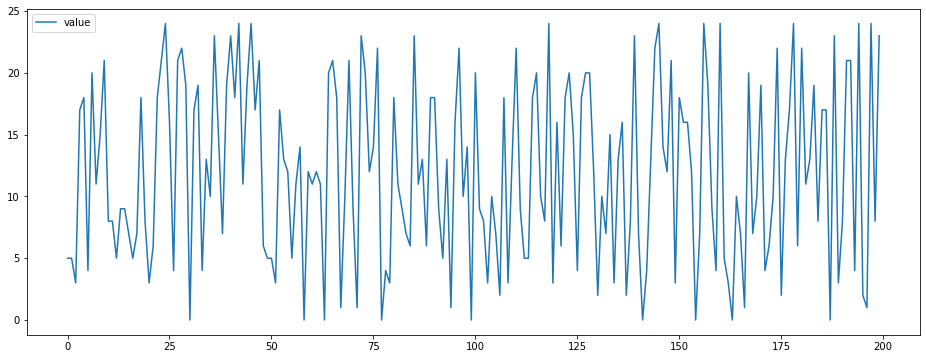

In [3]:
split_percentage = 0.8
train_size = int(len(df.index) * split_percentage)
df_train = df.iloc[:train_size]
df_validate = df.iloc[train_size:]

print(len(df_train.index))
print(len(df_validate.index))
df_train.plot(figsize=(16, 6))

We preprocess the data before feeding it to the model. This needs to be done for every prediction this model will do in the future too.

In [4]:
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train)

model_without_pipe = EllipticEnvelope(random_state=0, contamination=0.05)
model_without_pipe.fit(df_train_scaled)


EllipticEnvelope(assume_centered=False, contamination=0.05, random_state=0,
                 store_precision=True, support_fraction=None)

In [5]:
df_validate_scaled = scaler.transform(df_validate)
prediction_without_pipe = model_without_pipe.predict(df_validate_scaled)

If this model is uploaded to BYOML, it will expect scaled data as input. This means that you will need to do the scaler.transform(data_input) step for every prediction you run. Instead, this preprocessing step - and other preprocessing steps, even customized functions - can be included in the 'model' through a Pipeline.

In [6]:
model = EllipticEnvelope(random_state=0, contamination=0.05)
pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])

pipe.fit(df_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 EllipticEnvelope(assume_centered=False, contamination=0.05,
                                  random_state=0, store_precision=True,
                                  support_fraction=None))],
         verbose=False)

In [7]:
pipe_predictions = pipe.predict(df_validate)

pipe_predictions

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1])

In [8]:
model_name = 'sklearn-pipeline'

from waylay import  WaylayClient, RestResponseError
waylay = WaylayClient.from_profile()
waylay.byoml.model.upload(
    model_name=model_name,
    trained_model=pipe,
    framework='sklearn',
    description='Demo model sklearn pipelines.'
)


{'message': 'Model successfully uploaded'}

In [9]:
waylay.byoml.model.get(model_name)

{'createdBy': 'users/bd87db46-e8fc-4186-bdf4-a8f9478ed0d3',
 'createdOn': '2021-06-14T08:52:26.135479+00:00',
 'description': 'Demo model sklearn pipelines.',
 'framework': 'sklearn',
 'name': 'sklearn-pipeline',
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/bd87db46-e8fc-4186-bdf4-a8f9478ed0d3',
 'updatedOn': '2021-06-14T08:52:26.135513+00:00'}

In [10]:
prediction_with_pipe = waylay.byoml.model.predict(model_name, df_validate)

prediction_with_pipe

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1])

In [11]:
all(np.equal(prediction_with_pipe, prediction_without_pipe))

True

In [12]:
waylay.byoml.model.remove(model_name)

{'message': 'Model successfully deleted'}